# Hybrid Quantum-Enhanced Ensemble Classification (Grid Stability Workflow)

*Usage estimate: 12 minutes on ibm_brisbane. (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

This tutorial introduces a hybrid quantum–classical workflow designed to demonstrate how quantum optimization can enhance ensemble learning performance in real-world machine learning tasks. Using the *Singularity Machine Learning – Classification* function by Multiverse Computing, users will perform a complete end-to-end workflow for grid stability prediction, comparing classical ensemble baselines against a quantum-optimized alternative. The underlying technology combines classical ensemble techniques such as boosting and bagging with quantum algorithms like the Quantum Approximate Optimization Algorithm (QAOA), which optimizes the diversity and generalization of the trained ensemble. Unlike traditional quantum models limited by the number of qubits or dataset size, this function allows large-scale datasets with millions of examples to be processed efficiently, as the number of qubits only constrains the ensemble size. Through Qiskit Serverless, this tutorial shows how to connect, configure, and execute these hybrid workflows seamlessly on IBM’s managed quantum infrastructure—either through simulators or real QPUs—giving users both practical experience and an understanding of where quantum optimization can provide measurable benefits in classical learning pipelines.

## Requirements

Before starting this tutorial, ensure you have the following packages installed in your Python environment:

- Qiskit SDK v2.1.0 or later, with visualization support
- Qiskit Serverless v0.24.0 or later
- Qiskit IBM Catalog v0.8.0 or later
- scikit-learn v1.5.2
- pandas v2.x
- imbalanced-learn v0.12.3
- qiskit-ibm-runtime v0.40.1

You can install all required dependencies by running the following command:

In [1]:
%pip install -q "qiskit[visualization]~=2.1.0" "qiskit-serverless~=0.24.0" "qiskit-ibm-runtime~=0.40.1" "qiskit-ibm-catalog~=0.8.0" "scikit-learn==1.5.2" "pandas>=2.0.0,<3.0.0" "imbalanced-learn~=0.12.3"


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Setup

In this section, we initialize the Qiskit Serverless client and load the **Singularity Machine Learning – Classification** function provided by Multiverse Computing.
Qiskit Serverless allows you to run hybrid quantum–classical workflows on IBM’s managed cloud infrastructure without worrying about resource management.
You will need an **IBM Quantum Platform API key** and your **cloud resource name (CRN)** to authenticate and access Qiskit Functions.

### Download the dataset

To run this tutorial, we use a preprocessed **grid stability classification dataset** containing power system sensor readings labeled as *stable* or *unstable*.
The dataset is publicly hosted in the Multiverse Computing fork of the Qiskit documentation repository.
The following cell automatically creates the required folder structure and downloads both the training and test files directly into your environment using `wget`.
If you already have these files locally, this step will safely overwrite them to ensure version consistency.

In [2]:
## Download dataset for Grid Stability Classification

# Create data directory if it doesn't exist
!mkdir -p data_tutorial/grid_stability

# Download the training and test sets from the official Qiskit documentation repo
!wget -q --show-progress -O data_tutorial/grid_stability/train.csv \
  https://raw.githubusercontent.com/sepehr-multiverse/documentation/main/datasets/tutorials/grid_stability/train.csv

!wget -q --show-progress -O data_tutorial/grid_stability/test.csv \
  https://raw.githubusercontent.com/sepehr-multiverse/documentation/main/datasets/tutorials/grid_stability/test.csv

# Check the files have been downloaded
!echo "Dataset files downloaded:"
!ls -lh data_tutorial/grid_stability/*.csv

data_tutorial/grid_ 100%[===================>] 612.94K  --.-KB/s    in 0.04s   
data_tutorial/grid_ 100%[===================>] 108.19K  --.-KB/s    in 0.02s   
Dataset files downloaded:
-rw-r--r--@ 1 sepehr.hosseini  staff   108K 24 Oct 09:11 data_tutorial/grid_stability/test.csv
-rw-r--r--@ 1 sepehr.hosseini  staff   613K 24 Oct 09:11 data_tutorial/grid_stability/train.csv


### Import required packages

In this section, we import all Python packages and Qiskit modules used throughout the tutorial.
These include core scientific libraries for data handling and model evaluation—such as `NumPy`, `pandas`, and `scikit-learn`—along with visualization tools and IBM Qiskit components for running the quantum-enhanced model.
We also import the `QiskitRuntimeService` and `QiskitFunctionsCatalog` to connect with IBM Quantum services and access the **Singularity Machine Learning** function.

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_catalog import QiskitFunctionsCatalog
from typing import Tuple
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt

### Connect to IBM Quantum and load the Singularity Function

Next, we authenticate with IBM Quantum services and load the **Singularity Machine Learning – Classification** function from the Qiskit Functions Catalog.
The `QiskitRuntimeService` establishes a secure connection to the IBM Quantum Platform using your API token and instance CRN, allowing access to quantum backends.
The `QiskitFunctionsCatalog` is then used to retrieve the Singularity function by name (`"multiverse/singularity"`), enabling us to call it later for hybrid quantum–classical computation.
If the setup is successful, you will see a confirmation message indicating that the function has been loaded correctly.

In [4]:
IBM_TOKEN = ""
IBM_INSTANCE_TEST = ""
IBM_INSTANCE_QUANTUM = ""
FUNCTION_NAME = "multiverse/singularity"

service = QiskitRuntimeService(
    token=IBM_TOKEN,
    channel="ibm_quantum_platform",
    instance=IBM_INSTANCE_QUANTUM,
)

backend = service.least_busy()
catalog = QiskitFunctionsCatalog(
    token=IBM_TOKEN,
    instance=IBM_INSTANCE_TEST,
    channel="ibm_quantum_platform",
)
singularity = catalog.load(FUNCTION_NAME)
print(
    "Successfully connected to IBM Qiskit Serverless and loaded the Singularity function."
)

Successfully connected to IBM Qiskit Serverless and loaded the Singularity function.


### Define helper functions

Before running the main experiments, we define a few small utility functions that streamline data loading and model evaluation.
- `load_data()` reads the input CSV files into NumPy arrays, splitting features and labels for compatibility with scikit-learn and quantum workflows.
- `evaluate_predictions()` computes key performance metrics—accuracy, precision, recall, and F1-score—and optionally reports runtime if timing information is provided.

These helper functions simplify repeated operations later in the notebook and ensure consistent metric reporting across both classical and quantum classifiers.

In [5]:
def load_data(data_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Load data from the given path to X and y arrays."""
    df: pd.DataFrame = pd.read_csv(data_path)
    return df.iloc[:, :-1].values, df.iloc[:, -1].values


def evaluate_predictions(predictions, y_true, start_time=None, end_time=None):
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions)
    recall = recall_score(y_true, predictions)
    f1 = f1_score(y_true, predictions)
    if start_time is not None and end_time is not None:
        print("Time taken (s):", end_time - start_time)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    return accuracy, precision, recall, f1

## Step 1: Prepare and balance the dataset

We begin by loading the grid stability dataset and preparing it for model training and evaluation.
The data is split into training, validation, and test subsets using an 80/20 split for validation.
Because real-world grid stability data is often imbalanced—with significantly more stable than unstable samples—we apply **random over-sampling** using `imbalanced-learn` to balance the training set.
This ensures that both the classical AdaBoost baseline and the quantum-enhanced ensemble classifier learn from a representative distribution of classes.

At the end of this step, the code prints the shape of each data split to verify that the data has been correctly loaded and resampled.

In [6]:
RANDOM_STATE: int = 123
TRAIN_PATH = "data_tutorial/grid_stability/train.csv"
TEST_PATH = "data_tutorial/grid_stability/test.csv"
# Load and upload the data
X_train, y_train = load_data(TRAIN_PATH)
X_test, y_test = load_data(TEST_PATH)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

# Balance the dataset through over-sampling of the positive class
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

print(
    "Shapes:",
    "X_train_bal",
    X_train_bal.shape,
    "y_train_bal",
    y_train_bal.shape,
    "X_val",
    X_val.shape,
    "y_val",
    y_val.shape,
    "X_test",
    X_test.shape,
    "y_test",
    y_test.shape,
)

Shapes: X_train_bal (5104, 12) y_train_bal (5104,) X_val (850, 12) y_val (850,) X_test (750, 12) y_test (750,)


## Step 2: Optimize problem for quantum hardware execution

The ensemble selection task is cast as a combinatorial optimization problem where each weak learner is a binary decision variable and the objective balances accuracy with sparsity through a regularization term. The `QuantumEnhancedEnsembleClassifier` solves this with QAOA on IBM hardware, while still allowing simulator-based exploration. In this tutorial we configure a realistic production profile that scales to larger ensembles: we use 75 learners to mirror a strong classical baseline, set the regularization to favor compact yet accurate ensembles, and select a QAOA configuration that converges reliably within a practical time budget. The `optimizer_options` control the hybrid loop: `simulator=False` routes circuits to the selected QPU, `num_solutions` increases search breadth, and `classical_optimizer_options` (for the inner classical optimizer) govern convergence; values around 60 iterations are a good balance for quality and runtime. Runtime options such as moderate circuit depth (`reps`) and a standard transpilation effort help ensure robust performance across devices. The configuration below is the “best-results” profile we will use for hardware runs; you may also create a purely simulated variant by toggling `simulator=True` to dry-run the workflow without consuming QPU time.

In [7]:
# Problem scale and regularization
NUM_LEARNERS = 75  # ensemble size (also drives qubit count)
REGULARIZATION = 15  # favors smaller, less complex ensembles

# QAOA / runtime configuration for best results on hardware
optimizer_options = {
    "simulator": False,  # set True to test locally without QPU
    "num_solutions": 100_000,  # broaden search over candidate ensembles
    "reps": 3,  # QAOA depth (circuit layers)
    "optimization_level": 3,  # transpilation effort
    "num_transpiler_runs": 30,  # explore multiple layouts
    "classical_optimizer": "COBYLA",  # robust default for this landscape
    "classical_optimizer_options": {
        "maxiter": 10  # practical convergence budget
    },
    # You can pass backend-specific options; leaving None uses least-busy routing
    "estimator_options": None,
    "sampler_options": None,
}

print(
    "Configured hardware optimization profile:",
    f"\n  learners={NUM_LEARNERS}",
    f"\n  regularization={REGULARIZATION}",
    f"\n  optimizer_options={optimizer_options}",
)

Configured hardware optimization profile: 
  learners=75 
  regularization=15 
  optimizer_options={'simulator': False, 'num_solutions': 100000, 'reps': 3, 'optimization_level': 3, 'num_transpiler_runs': 30, 'classical_optimizer': 'COBYLA', 'classical_optimizer_options': {'maxiter': 10}, 'estimator_options': None, 'sampler_options': None}


## Step 3: Execute using Qiskit primitives

We now execute the full workflow and compare a strong classical baseline with the quantum-optimized ensemble. First, we train an AdaBoost classifier with an ensemble size comparable to the quantum configuration to establish a reproducible reference on the test set. Next, we invoke the Singularity Function’s `create_fit_predict` action to build, optimize, and evaluate the `QuantumEnhancedEnsembleClassifier` end-to-end on IBM infrastructure. The job returns predictions together with status and message fields that confirm successful execution. For convenience and reproducibility, we keep the classical train/validation split from Step 1 and pass the validation data into `fit_params` so the quantum optimization can use it internally for model selection without touching the held-out test set. After both runs complete, we compute accuracy, precision, recall, and F1 to enable a direct, task-level comparison.

In [8]:
# ----- Classical baseline: AdaBoost -----
baseline = AdaBoostClassifier(n_estimators=75, random_state=RANDOM_STATE)
baseline.fit(X_train_bal, y_train_bal)
baseline_pred = baseline.predict(X_test)

print("Classical AdaBoost baseline:")
_ = evaluate_predictions(baseline_pred, y_test)

# ----- Quantum-enhanced ensemble on IBM hardware -----
print("\n-- Submitting quantum-enhanced ensemble job --")
start = time.time()
job = singularity.run(
    action="create_fit_predict",
    name="grid_stability_qeec",
    quantum_classifier="QuantumEnhancedEnsembleClassifier",
    num_learners=NUM_LEARNERS,
    regularization=REGULARIZATION,
    optimizer_options=optimizer_options,  # from Step 2
    backend_name=backend,  # least-busy compatible backend
    instance=IBM_INSTANCE_QUANTUM,
    random_state=RANDOM_STATE,
    X_train=X_train_bal,
    y_train=y_train_bal,
    X_test=X_test,
    fit_params={"validation_data": (X_val, y_val)},
    options={"save": False},
)

# Retrieve result and evaluate
status = job.status()
result = job.result()
end = time.time()

print("\nQuantum job status:", status)
print("Action status:", result.get("status"))
print("Action message:", result.get("message"))

qeec_pred = np.array(result["data"]["predictions"])
print("\nQuantum-enhanced ensemble results:")
_ = evaluate_predictions(qeec_pred, y_test, start, end)

/Users/sepehr.hosseini/Documents/Qiskit/TUTORIAL (NOT LAB)/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classical AdaBoost baseline:
Accuracy: 0.7853333333333333
Precision: 1.0
Recall: 0.7853333333333333
F1: 0.8797610156833457

-- Submitting quantum-enhanced ensemble job --


/Users/sepehr.hosseini/Documents/Qiskit/TUTORIAL (NOT LAB)/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/utils/json.py:385: UserWarning: Callable <IBMBackend('ibm_kingston')> is not JSON serializable and will be set to None.
  warnings.warn(f"Callable {obj} is not JSON serializable and will be set to None.")



Quantum job status: QUEUED
Action status: ok
Action message: Classifier created, fitted, and predicted.

Quantum-enhanced ensemble results:
Time taken (s): 4531.2473039627075
Accuracy: 0.8506666666666667
Precision: 1.0
Recall: 0.8506666666666667
F1: 0.9193083573487032


## Step 4: Post-process and return result in desired classical format

After both executions finish, we summarize performance with standard classification metrics and a compact visualization. We compute accuracy, precision, recall, and F1 for the classical baseline and the quantum-enhanced ensemble on the same held-out test set, assemble the results into a small table for easy inspection, and render a simple bar chart comparing F1 scores. This concise post-processing highlights task-level differences without exposing the validation split, ensuring a clean, reproducible comparison between classical and quantum optimization paths.

Evaluation summary:


,Model,Accuracy,Precision,Recall,F1
0,AdaBoost (Classical),0.7853,1.0000,0.7853,0.8798
1,Quantum-Enhanced Ensemble,0.8507,1.0000,0.8507,0.9193


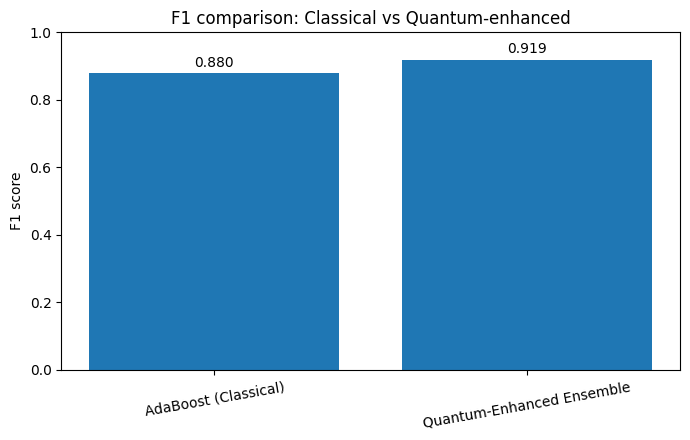

In [9]:
# Recompute metrics to ensure synchronized reporting
def metrics_dict(y_true, y_pred, label):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {
        "Model": label,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": rec,
        "F1": f1,
    }


summary = pd.DataFrame(
    [
        metrics_dict(y_test, baseline_pred, "AdaBoost (Classical)"),
        metrics_dict(y_test, qeec_pred, "Quantum-Enhanced Ensemble"),
    ]
)

print("Evaluation summary:")
display(
    summary.style.format(
        {
            "Accuracy": "{:.4f}",
            "Precision": "{:.4f}",
            "Recall": "{:.4f}",
            "F1": "{:.4f}",
        }
    )
)

# Bar chart comparing F1
plt.figure(figsize=(7, 4.5))
plt.bar(summary["Model"], summary["F1"])
plt.ylabel("F1 score")
plt.title("F1 comparison: Classical vs Quantum-enhanced")
for i, v in enumerate(summary["F1"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom")
plt.ylim(0, 1.0)
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

## Appendix: Scaling Benefits and Enhancements

The scalability advantage of the `QuantumEnhancedEnsembleClassifier` arises from how the ensemble-selection process maps to quantum optimization.
Classical ensemble learning methods, such as AdaBoost or random forests, become computationally expensive as the number of weak learners increases because selecting the optimal subset is a combinatorial problem that scales exponentially.

In contrast, the quantum formulation—implemented here via the Quantum Approximate Optimization Algorithm (QAOA)—can explore these exponentially large search spaces more efficiently by evaluating multiple configurations in superposition.
As a result, the training time grows with the number of learners, allowing the model to remain efficient even at larger ensemble scales.

While current hardware introduces some noise and depth limitations, this workflow demonstrates a near-term hybrid approach where classical and quantum components cooperate: the quantum optimizer provides a better initialization landscape for the classical loop, improving both convergence and final model accuracy.
As quantum processors evolve, these scaling benefits are expected to extend to larger datasets, more learners, and deeper circuit depths.

## References

- [\[1\]](#references) [Qiskit Function Tutorial](https://docs.quantum.ibm.com/guides/functions)
- [\[2\]](#references) [Qiskit Serverless Documentation](https://qiskit.github.io/qiskit-serverless/index.html)

## Tutorial survey

Please take a minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_3BLFkNVEuh0QBWm)